# Download dataset from: https://www.kaggle.com/datasets/sayanf/flickr8k

### Citations -
https://www.analyticsvidhya.com/blog/2021/01/implementation-of-attention-mechanism-for-caption-generation-on-transformers-using-tensorflow/

In [50]:
import string
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import glob

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from enum import Enum
import json

### Data preprocessing and Dataset cleanup

In [ ]:
# class syntax
class DataSplit(Enum):
    TRAIN = 0
    VAL = 1
    TEST = 2

MAX_TOKENIZED_LENGTH = 36

image_dir_path = "./archive/Flickr8k_Dataset/"
caption_file_path = './archive/Flickr8k_text/Flickr8k.token.txt'
train_img_file_path = './archive/Flickr8k_text/Flickr_8k.trainImages.txt'
test_img_file_path = './archive/Flickr8k_text/Flickr_8k.testImages.txt'
val_img_file_path = './archive/Flickr8k_text/Flickr_8k.devImages.txt'
images = os.listdir(image_dir_path)
captions_text = open(caption_file_path,'r').read()

print("Total Images in Dataset - {}\n".format(len(images)))
print("Sample Caption Details - \n{}".format(captions_text[:696]))

Captions Text to Dictionary

In [3]:
captions = dict()
for line in captions_text.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in captions:
              captions[image_id] = list()
          captions[image_id].append(image_desc)

Basic Text clean-up to convert all text to lower case and remove punctuations

In [4]:
table = str.maketrans('', '', string.punctuation)
for key, caption_list in captions.items():
    for i in range(len(caption_list)):
        desc = caption_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [word.translate(table) for word in desc]
        caption_list[i] =  ' '.join(desc).strip()

Sample Image and caption

In [ ]:
pic = '36422830_55c844bc2d.jpg'
x=plt.imread(image_dir_path+pic)
plt.imshow(x)
plt.show()
captions['36422830_55c844bc2d']

# Pre Process Text

Creating Vocabulary; Caption Tokenizer and padding

In [6]:
vocabulary = set()
for key in captions.keys():
        [vocabulary.update(d.split()) for d in captions[key]]

original_vocab_size = len(vocabulary)
        
print('Original Vocabulary Size: %d' % original_vocab_size)

Original Vocabulary Size: 8828


In [7]:
#Can Explore reducing the vocab size based on running experiments

In [8]:
def tokenize(x):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(x)
    t=tokenizer.texts_to_sequences(x)
    return t, tokenizer

In [52]:
def pad(x, length=MAX_TOKENIZED_LENGTH):
    padding=pad_sequences(x,padding='post',maxlen=length)
    return padding

In [10]:
all_captions_list = list()
for image_id in captions.keys():
    [all_captions_list.append(caption) for caption in captions[image_id]]

max_length = max(len(caption.split()) for caption in all_captions_list)
print('Description Length: %d' % max_length)

Description Length: 36


In [ ]:
print(all_captions_list)
caption_tokenized, text_tokenizer = tokenize(all_captions_list)
print(text_tokenizer.word_index)
print()

for i in range(5):
    print('Input:  {}'.format(all_captions_list[i]))
    print('Output: {}'.format(caption_tokenized[i]))

In [12]:
len(all_captions_list)

40460

In [ ]:
caption_padded = pad(caption_tokenized)

for i in range(5):
    print('Input:  {}'.format(caption_tokenized[i]))
    print('Output: {}'.format(caption_padded[i]))

Generating Train and Test Sets

In [14]:
train_img = open(train_img_file_path,'r').read()
train = list()
for line in train_img.split('\n'):
    if len(line) > 1:
      image_id = line.split('.')[0]
      train.append(image_id)
train = set(train)
print('Train Dataset size: %d' % len(train))


test_img = open(test_img_file_path,'r').read()
test = list()
for line in test_img.split('\n'):
    if len(line) > 1:
      image_id = line.split('.')[0]
      test.append(image_id)
test = set(test)
print('Test Dataset size: %d' % len(test))


val_img = open(val_img_file_path,'r').read()
val = list()
for line in val_img.split('\n'):
    if len(line) > 1:
      image_id = line.split('.')[0]
      val.append(image_id)
val = set(val)
print('Validation Dataset size: %d' % len(val))

Train Dataset size: 6000
Test Dataset size: 1000
Validation Dataset size: 1000


In [15]:
images = glob.glob(image_dir_path + '*.jpg')

In [16]:
train_images = set(open(train_img_file_path, 'r').read().strip().split('\n'))
train_img = []
for i in images: 
    if i[len(image_dir_path):] in train_images:
        train_img.append(i)
        
test_images = set(open(test_img_file_path, 'r').read().strip().split('\n'))
test_img = []
for i in images: 
    if i[len(image_dir_path):] in test_images: 
        test_img.append(i)
        
val_images = set(open(val_img_file_path, 'r').read().strip().split('\n'))
val_img = []
for i in images: 
    if i[len(image_dir_path):] in val_images: 
        val_img.append(i)

print('Train Dataset size: %d' % len(train_img))
print('Test Dataset size: %d' % len(test_img))
print('Validation Dataset size: %d' % len(val_img))

Train Dataset size: 6000
Test Dataset size: 1000
Validation Dataset size: 1000


In [ ]:
# Save the plaintext and tokenized captions per image filename in dicts
# Args: Enum DataSplit split type
# Return: (plaintext_caption list, tokenized_caption list)
def save_final_text_split(split_type):
    # Get the split type we're working with
    split_set = None
    if split_type == DataSplit.TRAIN:
        split_set = train
    if split_type == DataSplit.VAL:
        split_set = val
    if split_type == DataSplit.TEST:
        split_set = test

    # Parse out the captions + tokenize
    plaintext_captions = dict()
    token_captions = dict()
    for image_id in captions.keys():
        if image_id in split_set:
            if image_id not in plaintext_captions:
                plaintext_captions[image_id] = list()
            for caption in captions[image_id]:
                new_caption = 'startseq ' + caption + ' endseq'
                plaintext_captions[image_id].append(new_caption)
            token_captions[image_id] = pad(text_tokenizer.texts_to_sequences(plaintext_captions[image_id]))
    
    return plaintext_captions, token_captions

train_captions, tok_train_captions = save_final_text_split(DataSplit.TRAIN)
val_captions, tok_val_captions = save_final_text_split(DataSplit.VAL)
test_captions, tok_test_captions = save_final_text_split(DataSplit.TEST)

print("EXAMPLE")
print(f"Train Captions size: {len(train_captions)}\n")
print(f"Caption before - \n {captions['36422830_55c844bc2d']}\n")
print(f"Caption after - \n {train_captions['36422830_55c844bc2d']}\n")
print(f"Tokenized captions - \n {tok_train_captions['36422830_55c844bc2d']}\n")


# Pre-process Images

cite:- https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa (TODO: params changes & image cleanup, for now just for understanding)

We will use a pre-trained Inception model, We download this pre-trained model, truncate the Classifier section and encode the training images. The features for each encoded image are saved in a separate file using the image name and another extension eg. ‘1000268201_693b08cb0e.npy’

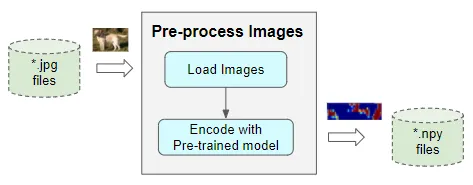

In [18]:

# TODO: Cleanup Comments
# We must remember that we do not need to classify the images here, 
# we only need to extract an image vector for our images. 
# Hence we remove the softmax layer from the model. We must all 
# preprocess all the images to the same size, i.e, 299×299

# TODO: Looks like this is just copied code

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [19]:
# TODO: Looks like this is just copied code

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
# TODO: Looks like this is just copied code
import pathlib

# pre processing Images in the same path as images earlier.
# Get unique images so set
encoded_img_set = set(train_img)
encoded_img_set.update(val_img)
encoded_img_set.update(test_img)
encoded_img_set = sorted(encoded_img_set)

# batch_size according to system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encoded_img_set)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# image_features_extract_model CNN model on images
# We extract the features and store them in the respective .npy files
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())